In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random # to randomize our batch data

import torch

import itertools
from sklearn.metrics import confusion_matrix
from scipy.io import savemat # to save our features representations
from scipy.io import loadmat # to load our features representations
from sklearn import svm # to check our accuracy

from sklearn.cluster import MiniBatchKMeans, KMeans

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import time # to record our work's time
import pickle

In [96]:
# just something for the confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
#     print(cm) # uncomment if you want to print like normal data
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [101]:
# function to just plot both normalizes and normal matrix

def print_confusion_matrix(test_label, predictions):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(test_label, predictions)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names_matrix,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names_matrix, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

In [97]:
#Prepare dataset

# function to parse the actions.txt file to get the name of all actions
# function to parse the file whose filename is passed
# return type: data set of all the class names
def get_typemoney_classes(fileName):
    File = str(fileName)
    row = []
    category = []
    with open(File) as inFile: #opening the file to scrap data
        for line in inFile: #separating each line
            items = line.strip().split(',') #splits the string into an array
            for each in items:
                record = each.strip().split('  ')
                category.append(record[1])
    return category

In [5]:
# function to parse the videos_labels_subsets.txt file 
# to get all the labels associated with each set of video representation
#function to parse the file whose filename is passed
#return type: train,train_labels, test, test_labels
def get_image_labels(fileName):
    File = str(fileName)
    row = []
    category = []
    with open(File) as inFile: #opening the file to scrap data
        for line in inFile: #separating each line
            items = line.strip().split(',') #splits the string into an array
            for each in items:
                record = each.strip().split('\t')
                row.append(record)
    return seperate_data(row) # return data set

In [6]:
# a helper function for get_image_labels(filename)
# gets the labels and tag associated with each video 
# and divides them into test and training data names and labels
#return type: train,train_labels, test, test_labels
def seperate_data(label_names):
    train = []
    test = []
    train_labels = []
    test_labels = []
    for item in label_names:
        if (item[2]=='1'):
            train.append(item[0])
            train_labels.append(int(item[1]))
        else:
            test.append(item[0])
            test_labels.append(int(item[1]))
    return train, train_labels, test, test_labels

In [7]:
file_annos = './data/annos.txt'
file_images = './data/images_labels_subsets.txt'

In [8]:
class_names_all = get_typemoney_classes(file_annos) #get all action names
class_names = dict(zip(range(1, len(class_names_all)+1), class_names_all))
# change it into a dictionary for each access

print("The visual system is made to recognise the following tasks:")
[(print(x,"|", class_names[x])) for x in class_names]

# get all labels and name of training and test data features
train, train_labels, test, test_labels = get_image_labels(file_images)

The visual system is made to recognise the following tasks:
1 | 500vnd
2 | 1000vnd
3 | 2000vnd
4 | 5000vnd
5 | 10000vnd
6 | 20000vnd
7 | 50000vnd
8 | 100000vnd
9 | 200000vnd
10 | 500000vnd


In [9]:
# function which returns a list of cropped images for a passed image
# works with images passed as normal numpy array or a tensor
# passed argument: image itself, what size you want the crops to be
# returns only a list of numpy cropped images
# uncomment to change into tensors for tensors
def get_five_crops(img, size):
    s_h, s_w = size
    crop = []
    is_tensor = torch.is_tensor(img)
    # change into a numpy array properly if it is tensor
    # Tensor image's shape -> channels*height*width
    # Numpy image's shape -> height*width*channels
    if (is_tensor):
        temp = img.numpy()
        temp = np.transpose(temp, [1, 2, 0])
        img = temp
        
    height, width, color = img.shape
    crop.append(img[0:s_h, 0:s_w]) #image 1
    crop.append(img[0:s_h, (width-s_w):width]) #image 2
    crop.append(img[(height-s_h):height, 0:s_w]) #image 3
    crop.append(img[(height-s_h):height, (width-s_w):width]) #image 4
    mid_y = int(height/2 - s_h/2)
    mid_x = int(width/2 - s_w/2)
    crop.append(img[mid_y:(mid_y + s_h), mid_x:(mid_x + s_w)]) # image 5 # center

#     uncomment to change into tensors for tensors
#     if (is_tensor):
#         for i, each in enumerate(crop):
#             crop[i] = torch.from_numpy(each.transpose(2,0,1))
    return crop 

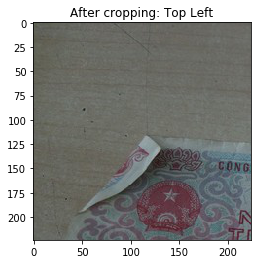

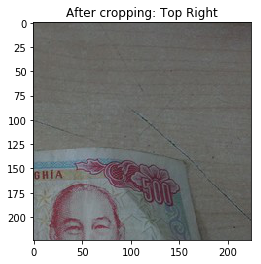

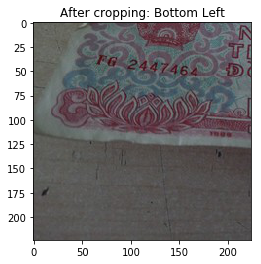

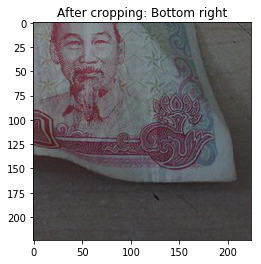

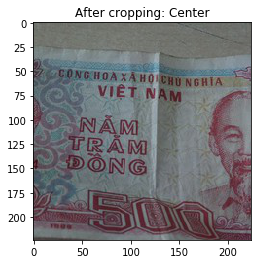

In [14]:
#img_size = (300, 300)
img_size = (224, 224)
img = cv2.imread('data/vnmoney/00/1.jpg')
arr = ['Top Left', 'Top Right', 'Bottom Left', 'Bottom right', 'Center']
for i, img1 in enumerate(get_five_crops(img, img_size)):
    plt.figure()
    plt.title('After cropping: ' + arr[i])
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.show()

In [24]:
def sift(img):
    sift = cv2.xfeatures2d.SIFT_create()
    _, des = sift.detectAndCompute(img,None)
    return des

In [26]:
def load_dataset(path, data_name, data_labels, img_size):
    desdata = []
    labels = []
    idx = 0
    
    for image_name in data_name:
        filename = path+image_name+".jpg"
        img = cv2.imread(filename)
        crops = get_five_crops(img, img_size)
        for i in crops:
            desdata.append(sift(i))
            labels.append(data_labels[idx])
        idx+=1
    return desdata, labels

In [29]:
s = time.clock()
#img_size = (300, 300)
img_size = (224, 224)

path = 'data/vnmoney/'
vnmoney_train_data, vnmoney_train_labels = load_dataset(path, train, train_labels, img_size)
vnmoney_train_num = len(vnmoney_train_data)

# load train dataset for feature extraction
vnmoney_test_data, vnmoney_test_labels = load_dataset(path, test, test_labels, img_size)
vnmoney_test_num = len(vnmoney_test_data)

print ("Finish loading %d minibatches of train samples." % (vnmoney_train_num))
print ("Finish loading %d minibatches of test samples." % (vnmoney_test_num))
e = time.clock()

print("Time Taken: ", int((e-s)//60), "min and", float((e-s)%60),"sec")

Finish loading 700 minibatches of train samples.
Finish loading 300 minibatches of test samples.
Time Taken:  1 min and 8.181733000000008 sec


In [1]:
def cluster_features(img_descs, cluster_model):
    """
    Cluster the training features using the cluster_model
    and convert each set of descriptors in img_descs
    to a Visual Bag of Words histogram.

    Parameters:
    -----------
    X : list of lists of SIFT descriptors (img_descs)

    training_idxs : array/list of integers
        Indicies for the training rows in img_descs

    cluster_model : clustering model (eg KMeans from scikit-learn)
        The model used to cluster the SIFT features

    Returns:
    --------
    cluster_mode :
    cluster_model has been fit to the training set
    """
    n_clusters = cluster_model.n_clusters
    des_stack_train=[desc for img in img_descs for desc in img]
    all_train_descriptors = np.array(des_stack_train)

    if all_train_descriptors.shape[1] != 128:
        raise ValueError('Expected SIFT descriptors to have 128 features, got', all_train_descriptors.shape[1])

    print ('%i descriptors before clustering' % all_train_descriptors.shape[0])

    # Cluster descriptors to get codebook
    print ('Using clustering model %s...' % repr(cluster_model))
    print ('Clustering on training set to get codebook of %i words' % n_clusters)

    # train kmeans or other cluster model on those descriptors selected above
    cluster_model.fit(all_train_descriptors)
    
    
    print ('done clustering.')
    
    return cluster_model

In [2]:
def histogram(cluster_model,des,K):
    words = cluster_model.predict(des)
    img_bow_hist = np.array([np.bincount(words, minlength=K)])
    return img_bow_hist

In [39]:
def cluster_split(_X_train, _X_test, K):
    s = time.clock()
    # building cluster model
    cluster_model = cluster_features(_X_train, cluster_model=MiniBatchKMeans(n_clusters=K))
    
    X_train=[]   # initialising array of input vectors for training set
    
    print ('\n calculting histogram vectors of training set')
    for des in _X_train:
        hist=histogram(cluster_model,des,K)
        X_train.append(hist)
    X_train=np.array(X_train)
    
    # building validation set in terms of labels and vectors
    #X_val=[]
   # print '\n computing descriptors of validation data and producing corresponding labels'
    #des_val,Y_val=decs_train(validation,labeled_data)
    
   # print '\n calculting histogram vectors of validation set'
   # for des in des_val:
     #   hist=histogram(cluster_model,des,K)
     #   X_val.append(hist)
    #X_val=np.array(X_val)
    
    # building test set in terms of labels and vectors
    X_test=[]
    
    print ('\n calculting histogram vectors of test set')
    for des in _X_test:
        hist=histogram(cluster_model, des, K)
        X_test.append(hist)
    X_test=np.array(X_test)
    print("Done")
    e = time.clock()
    print("Time Taken: ", int((e-s)//60), "min and", float((e-s)%60),"sec")
    return X_train,X_test, cluster_model

In [44]:
def run_svm(X_train, X_test, Y_train, Y_test, scoring,
    c_vals=[1, 5, 10], gamma_vals=[0.1, 0.01, 0.0001, 0.00001]):

    param_grid = [
    #   {'C': c_vals, 'kernel': ['linear']},
      {'C': c_vals, 'gamma': gamma_vals, 'kernel': ['rbf']},
     ]

    svc = GridSearchCV(SVC(), param_grid, n_jobs=-1, cv=10, scoring=scoring)
    svc.fit(X_train, Y_train)
    print ('train score (%s):'%scoring, svc.score(X_train, Y_train))
    test_score = svc.score(X_test, Y_test)
    print ('test score (%s):'%scoring, test_score)

    print (svc.best_estimator_)

    return svc, test_score

In [88]:
K = 600
X_train, X_test, cluster_model = cluster_split(vnmoney_train_data, vnmoney_test_data, K)
Y_train, Y_test = vnmoney_train_labels, vnmoney_test_labels

160894 descriptors before clustering
Using clustering model MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=600, n_init=3, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=0)...
Clustering on training set to get codebook of 600 words


/home/trimo/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1556: RuntimeWarning: init_size=300 should be larger than k=600. Setting it to 3*k
  init_size=init_size)
/home/trimo/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1556: RuntimeWarning: init_size=300 should be larger than k=600. Setting it to 3*k
  init_size=init_size)
/home/trimo/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1556: RuntimeWarning: init_size=300 should be larger than k=600. Setting it to 3*k
  init_size=init_size)


done clustering.

 calculting histogram vectors of training set

 calculting histogram vectors of test set
Done
Time Taken:  2 min and 5.522722999999928 sec


In [91]:
s = time.clock()
results = {}
scoring = 'recall_micro'
X_train = X_train.reshape(len(X_train), K)
X_test = X_test.reshape(len(X_test), K)
print ('\nSVM Scores: ')
svmGS, svm_score = run_svm(X_train, X_test, Y_train, Y_test, scoring)
    
results[K] = dict(svmGS=svmGS,cluster_model=cluster_model,svm_score=svm_score)
print ('\n*** K=%i DONE ***\n' % K)
e = time.clock()
print("Time Taken: ", int((e-s)//60), "min and", float((e-s)%60),"sec")


SVM Scores: 
train score (recall_micro): 0.9757142857142858
test score (recall_micro): 0.9
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

*** K=600 DONE ***



{1: '500vnd', 2: '1000vnd', 3: '2000vnd', 4: '5000vnd', 5: '10000vnd', 6: '20000vnd', 7: '50000vnd', 8: '100000vnd', 9: '200000vnd', 10: '500000vnd'}


<Figure size 432x288 with 0 Axes>

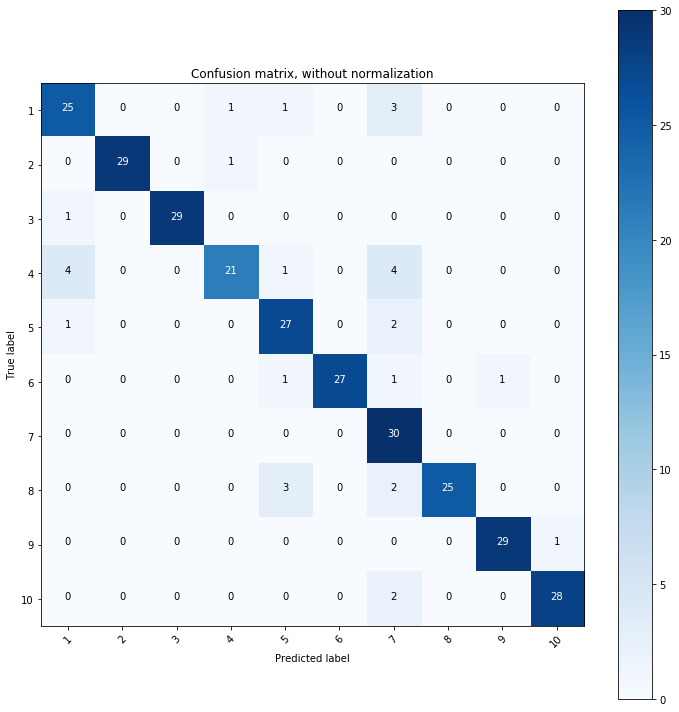

<Figure size 432x288 with 0 Axes>

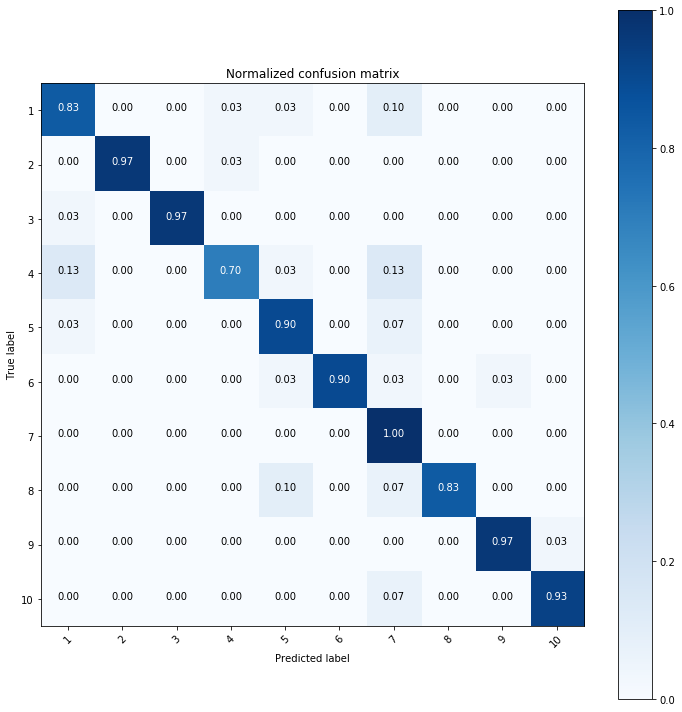

In [102]:
class_names_matrix = class_names_all
class_names_matrix = dict(zip(range(1, len(class_names_matrix)+1), class_names_matrix))
print (class_names_matrix)
predicted_train_labels_svm =  svmGS.predict(X_test)
print_confusion_matrix(Y_test, predicted_train_labels_svm)

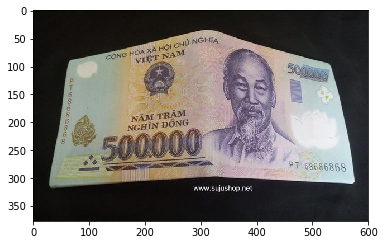

[6 6 0 6 8]
this is:   50000vnd


In [95]:
imgtest = cv2.imread('./data/test/500k.jpg')
plt.imshow(cv2.cvtColor(imgtest, cv2.COLOR_BGR2RGB))
plt.show()
crops = get_five_crops(imgtest, (224,224))
datades = [sift(i) for i in crops]
data = np.array([histogram(cluster_model, des, K) for des in datades])
data = data.transpose([1,0,2]).reshape(data.shape[0], data.shape[2])
outputs = svmGS.predict(data)
predicted = np.argmax(np.bincount(outputs))

print(outputs)
print ("this is:  ", class_names[predicted+1])

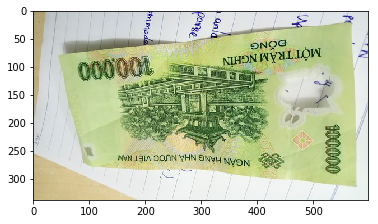

[7 7 7 7 7]
this is:   100000vnd


In [103]:
imgtest = cv2.imread('./data/test/2.jpg')
plt.imshow(cv2.cvtColor(imgtest, cv2.COLOR_BGR2RGB))
plt.show()
crops = get_five_crops(imgtest, (224,224))
datades = [sift(i) for i in crops]
data = np.array([histogram(cluster_model, des, K) for des in datades])
data = data.transpose([1,0,2]).reshape(data.shape[0], data.shape[2])
outputs = svmGS.predict(data)
predicted = np.argmax(np.bincount(outputs))

print(outputs)
print ("this is:  ", class_names[predicted+1])

#SVM LinearSVC
---

In [104]:

classifier_svm = svm.LinearSVC()

# As my machine is not capable of doing an SVM of all training data at once

s= time.clock()
print ("Training Started...")
classifier_svm.fit(np.array(X_train), Y_train) #fitting and training
print ("Training Finished...")
e = time.clock()
print ("Time Taken : " + str(e-s))

Training Started...
Training Finished...
Time Taken : 0.3144839999999931


/home/trimo/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [105]:
svm_save  = classifier_svm.get_params(True)
print (svm_save)

# save the classifier
with open('SIFT_svm_model/svm_classifier.pkl', 'wb') as fid:
    pickle.dump(classifier_svm, fid)    

{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [106]:
# method for getting accuracy when a train label set and test label set is passed
def get_accuracy(actual_label, predicted_label):
    accuracy = sum(np.array(actual_label) == predicted_label) / float(len(actual_label))
    return accuracy

In [108]:
# training accuracy
predicted_train_labels_svm = classifier_svm.predict(X_train) # getting the predicted labels
S = get_accuracy(Y_train , predicted_train_labels_svm) # getting the accuracy
print ("The training accuracy of my model using SVM is {:.2f}%".format(S*100))

The training accuracy of my model using SVM is 100.00%


In [109]:
predicted_test_labels_svm = classifier_svm.predict(X_test) # getting the predicted labels
S = get_accuracy(Y_test , predicted_test_labels_svm) # getting the accuracy
print ("The testing accuracy of my model using SVM is {:.2f}%".format(S*100))

The testing accuracy of my model using SVM is 91.33%


{1: '500vnd', 2: '1000vnd', 3: '2000vnd', 4: '5000vnd', 5: '10000vnd', 6: '20000vnd', 7: '50000vnd', 8: '100000vnd', 9: '200000vnd', 10: '500000vnd'}


<Figure size 432x288 with 0 Axes>

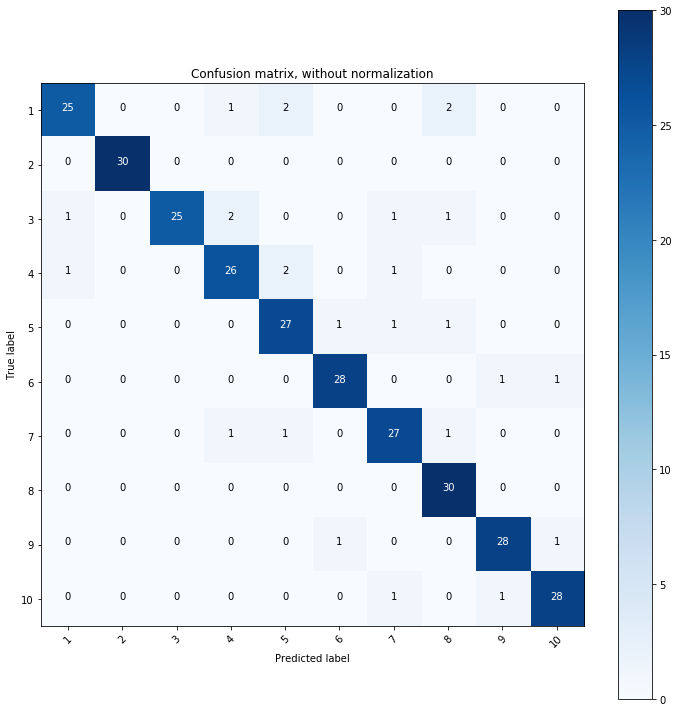

<Figure size 432x288 with 0 Axes>

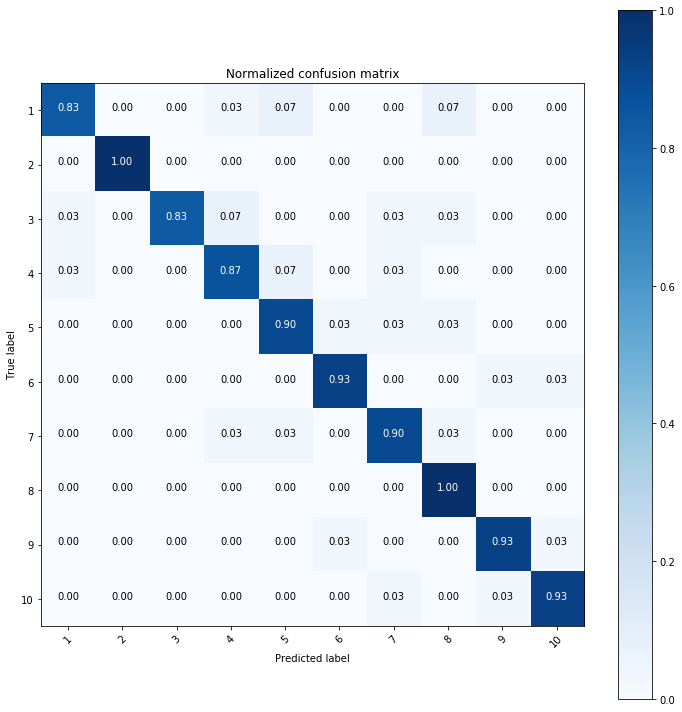

In [110]:
# here, we just want to show the labels that we are using
class_names_matrix = class_names_all[0:20]
class_names_matrix = dict(zip(range(1, len(class_names_matrix)+1), class_names_matrix))
print (class_names_matrix)
print_confusion_matrix(Y_test, predicted_test_labels_svm)

In [114]:
#=========================
# load it again
with open('SIFT_svm_model/svm_classifier.pkl', 'rb') as fid:
    classifier_svm = pickle.load(fid)

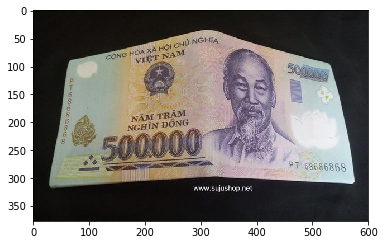

[5 3 5 8 7]
this is:   20000vnd


In [112]:
imgtest = cv2.imread('./data/test/500k.jpg')
plt.imshow(cv2.cvtColor(imgtest, cv2.COLOR_BGR2RGB))
plt.show()
crops = get_five_crops(imgtest, (224,224))
datades = [sift(i) for i in crops]
data = np.array([histogram(cluster_model, des, K) for des in datades])
data = data.transpose([1,0,2]).reshape(data.shape[0], data.shape[2])
outputs = classifier_svm.predict(data)
predicted = np.argmax(np.bincount(outputs))

print(outputs)
print ("this is:  ", class_names[predicted+1])

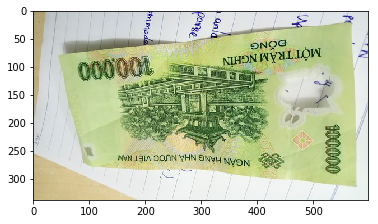

[7 7 7 7 7]
this is:   100000vnd


In [113]:
imgtest = cv2.imread('./data/test/2.jpg')
plt.imshow(cv2.cvtColor(imgtest, cv2.COLOR_BGR2RGB))
plt.show()
crops = get_five_crops(imgtest, (224,224))
datades = [sift(i) for i in crops]
data = np.array([histogram(cluster_model, des, K) for des in datades])
data = data.transpose([1,0,2]).reshape(data.shape[0], data.shape[2])
outputs = classifier_svm.predict(data)
predicted = np.argmax(np.bincount(outputs))

print(outputs)
print ("this is:  ", class_names[predicted+1])